# Model selection

### Import necessary packages

In [259]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

### Read data into pandas Dataframe

In [276]:
train_df = pd.read_csv('datasets/train.csv', index_col='PassengerId')
X = train_df.drop('Survived', axis='columns')
y = train_df.Survived

### Preprocessing data

In [277]:
# Convert Pclass dtype to categorical
X.Pclass = X.Pclass.astype('category', ordered=False)

#Fill Embarked column with 'None' where NA
X.Cabin.fillna('None', inplace=True)

#Fill null values in numeric columns
numeric_columns = X.select_dtypes(include='number').columns.values
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())

#Fill null values in string columns
categorical_columns = X.select_dtypes(exclude='number').columns.values
X[categorical_columns] = X[categorical_columns].apply(lambda x:x.fillna(x.value_counts().index[0]))

X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [278]:
X.isna().any()

Pclass      False
Name        False
Sex         False
Age         False
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin       False
Embarked    False
dtype: bool

### Feature engineering

In [279]:
# Combine SibSp and ParCh into single column FamilySize
X['FamilySize'] = X.SibSp + X.Parch + 1

# Define IsAlome from FamilySize
X['IsAlone'] = (X.FamilySize == 1).astype('category', ordered=False)

# Convert Age to a categorical variable
X.Age.fillna(X.Age.median(), inplace=True)
X['AgeCategory'] = pd.cut(X.Age, bins=5, labels=np.arange(5)).astype('category', ordered=False)

# Convert Fare to a categorical variable
X.Fare.fillna(X.Age.median(), inplace=True)
X['FareCategory'] = pd.cut(X.Age, bins=4, labels=np.arange(4)).astype('category', ordered=False)

# Create column HasCabin from Cabin
X['HasCabin'] = (X.Cabin != 'None').astype('category', ordered=False)

X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,AgeCategory,FareCategory,HasCabin
PassengerId,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,2,False,1,1,False
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,False,2,1,True
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,1,True,1,1,False
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,False,2,1,True
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S,1,True,2,1,False


### Dropping unwanted features

In [280]:
X.drop(['Name', 'Age', 'SibSp', 'Parch', 'Cabin', 'Ticket', 'Fare'], axis='columns', inplace=True)
X.head()

,Pclass,Sex,Embarked,FamilySize,IsAlone,AgeCategory,FareCategory,HasCabin
PassengerId,,,,,,,,
1,3,male,S,2,False,1,1,False
2,1,female,C,2,False,2,1,True
3,3,female,S,1,True,1,1,False
4,1,female,S,2,False,2,1,True
5,3,male,S,1,True,2,1,False


#### Encoding

In [282]:
X.Sex = LabelEncoder().fit_transform(X.Sex)
X.Embarked = LabelEncoder().fit_transform(X.Embarked)
X.Embarked = X.Embarked.astype('category', ordered=False)
X.IsAlone = LabelEncoder().fit_transform(X.IsAlone)
X.HasCabin = LabelEncoder().fit_transform(X.HasCabin)
X_encoded = pd.concat((X[['Sex', 'FamilySize', 'IsAlone', 'HasCabin']], 
           pd.get_dummies(X[['Pclass', 'Embarked', 'AgeCategory', 'FareCategory']])), axis=1)
X_encoded.head()

,Sex,FamilySize,IsAlone,HasCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_0,Embarked_1,Embarked_2,AgeCategory_0,AgeCategory_1,AgeCategory_2,AgeCategory_3,AgeCategory_4,FareCategory_0,FareCategory_1,FareCategory_2,FareCategory_3
PassengerId,,,,,,,,,,,,,,,,,,,
1,1,2,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0
2,0,2,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0
4,0,2,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
5,1,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0


### Feature selection

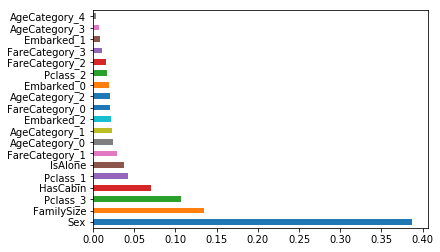

In [286]:
model = RandomForestClassifier().fit(X_encoded, y)
pd.Series(model.feature_importances_, index=X_encoded.columns).sort_values(ascending=False).plot(kind='barh')
X_feature_selected = SelectFromModel(RandomForestClassifier(), threshold=0.005).fit_transform(X_encoded, y)

In [287]:
X_feature_selected.shape

(891, 18)

### Principal Component Analysis to visualise in 2D

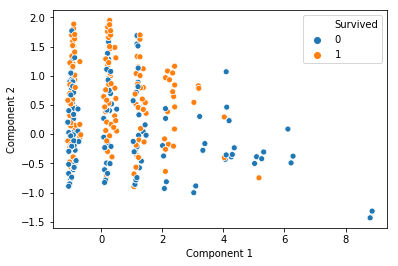

In [288]:
pca_model = PCA(n_components=2)
X_pca = pca_model.fit_transform(X_feature_selected)
sns.scatterplot(X_pca[:,0], X_pca[:,1], hue=y)
plt.xlabel('Component 1')
plt.ylabel('Component 2');

### Splitting dataset into training and test sets

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X_feature_selected, y, random_state=0, stratify=y)

### Trying out different models

In [290]:
%%time
#Logistic Regression
param_grid = {
    'C': np.logspace(-2, -1, 10)
}
model = GridSearchCV(LogisticRegression(), param_grid=param_grid, n_jobs=-1)
model.fit(X_train, y_train)
print('Training score: {}'.format(model.score(X_train, y_train)))
print('Test score: {}'.format(model.score(X_test, y_test)))
print('Best params: {}'.format(model.best_params_))

Training score: 0.8173652694610778
Test score: 0.7937219730941704
Best params: {'C': 0.05994842503189409}
CPU times: user 124 ms, sys: 48.7 ms, total: 173 ms
Wall time: 231 ms


In [291]:
%%time
# Random Forest
param_grid = {
    'n_estimators': [1000],
    'max_depth': np.arange(1, 6)
}
model = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)
print('Training score: {}'.format(model.score(X_train, y_train)))
print('CV score: {}'.format(model.best_score_))
print('Test score: {}'.format(model.score(X_test, y_test)))
print('Best params: {}'.format(model.best_params_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   11.9s finished


Training score: 0.8308383233532934
CV score: 0.8068862275449101
Test score: 0.820627802690583
Best params: {'max_depth': 4, 'n_estimators': 1000}
CPU times: user 1.94 s, sys: 45.8 ms, total: 1.98 s
Wall time: 13.9 s


In [292]:
%%time
# Support Vector Classifier
param_grid = [
    {
        'kernel': ['rbf'],
        'C': np.logspace(0, 3, 10),
        'gamma': np.logspace(-3, 3, 10),   
    }
    
]
model = GridSearchCV(SVC(), param_grid=param_grid, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)
print('Training score: {}'.format(model.score(X_train, y_train)))
print('CV score: {}'.format(model.best_score_))
print('Test score: {}'.format(model.score(X_test, y_test)))
print('Best params: {}'.format(model.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    2.1s


Training score: 0.8293413173652695
CV score: 0.8218562874251497
Test score: 0.8026905829596412
Best params: {'C': 10.0, 'gamma': 0.021544346900318832, 'kernel': 'rbf'}
CPU times: user 451 ms, sys: 44.4 ms, total: 495 ms
Wall time: 3.15 s


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.9s finished


In [293]:
%%time
# XGBoost
param_grid = {
    'n_estimators': [1000],
}
model = GridSearchCV(XGBClassifier(), param_grid=param_grid, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)
print('Training score: {}'.format(model.score(X_train, y_train)))
print('CV score: {}'.format(model.best_score_))
print('Test score: {}'.format(model.score(X_test, y_test)))
print('Best params: {}'.format(model.best_params_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Training score: 0.8667664670658682
CV score: 0.7874251497005988
Test score: 0.7982062780269058
Best params: {'n_estimators': 1000}
CPU times: user 521 ms, sys: 42.5 ms, total: 564 ms
Wall time: 1.06 s


#### Improving the model

In [349]:
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('xgb', XGBClassifier()),
])
param_grid = {
    'pca__n_components': np.arange(1, X_train.shape[1], 2),
    'xgb__n_estimators': [2000],
    'xgb__learning_rate': np.logspace(-2, -1, 10),
    'xgb__max_depth': np.arange(1, 6),
    'xgb__gamma': np.arange(0.7, 1.0, 0.1),
    'xgb__n_jobs':[-1],
}
model = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)
print('Training score: {}'.format(model.score(X_train, y_train)))
print('CV score: {}'.format(model.best_score_))
print('Test score: {}'.format(model.score(X_test, y_test)))
print('Best params: {}'.format(model.best_params_))

Fitting 3 folds for each of 1800 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 27.9min finished


Training score: 0.8413173652694611
CV score: 0.812874251497006
Test score: 0.820627802690583
Best params: {'pca__n_components': 9, 'xgb__gamma': 0.7999999999999999, 'xgb__learning_rate': 0.01291549665014884, 'xgb__max_depth': 1, 'xgb__n_estimators': 2000, 'xgb__n_jobs': -1}


Training score: 0.8413173652694611
CV score: 0.812874251497006
Test score: 0.820627802690583
Best params: {'pca__n_components': 9, 'xgb__gamma': 0.9, 'xgb__learning_rate': 0.05623413251903491, 'xgb__max_depth': 1, 'xgb__n_estimators': 2000, 'xgb__n_jobs': -1}

### Saving the model for later predictions

In [350]:
joblib.dump(model, 'model.pkl')

['model.pkl']